In [29]:
# pandas
import pandas as pd

# övrigt
import os
import warnings

# visualisering
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

**November 2018**

Reporter Cecilia Granestrand ska skriva en trendartikel om kostnadsökningen inom skolan. Artikelidén kommer från [en statistiknyhetfrån SCB](https://www.scb.se/hitta-statistik/statistik-efter-amne/utbildning-och-forskning/befolkningens-utbildning/kostnader-for-utbildningsvasendet/pong/statistiknyhet/kostnader-for-utbildningsvasendet-2013-2017/) om att kostnader per gymnasieelev har stigit med 10 procent. 

Efter samtal med Jose-Luis Berrospi på Skolverket (08-527 333 56) har gjort en rapport som visar hur kostnadsutvecklingen sett ut i grundskolan sedan 2000. Vi valde att fokusera på de senaste 10 åren. Resultatet publicerades i tidningen nr 42 och finns [att läsa på webben här](https://dagenssamhalle.se/nyhet/mer-pengar-gar-till-undervisning-25128).

### Datatvätt

Först hämta all data från datafilerna. Dessa är i sig tvättade. Vill man se hur grunddatafilerna ser ut så finns dessa i mappen "grund" i mappen "data". Data hämtades från [Skolverkets sida för statistik](https://www.skolverket.se/skolutveckling/statistik/sok-statistik-om-forskola-skola-och-vuxenutbildning).

För data på elever: Egentligen är varje års elevantal från höstterminen för respektive år. Så 2017 är egentligen läsåret 2017/18. 

Import av data:

In [30]:
df = pd.DataFrame()
for file in os.listdir('data/'):
    if ".xls" in file:
        if "elev" in file:
            continue
        year = file[:4]
        temp = pd.read_excel(f'data/{file}',sheet_name="Blad1").set_index('Huvudman').T
        temp['år'] = year
        
        df = pd.concat([df,temp])
        

Formattera kolumner (Skolverkets data är verkligen vidrig...):

In [31]:
df.columns = df.columns.str.replace("%","")\
                        .str.strip()\
                        .str.replace(",","")\
                        .str.strip()\
                        .str.replace("\(","")\
                        .str.strip()\
                        .str.replace("\)","")\
                        .str.strip()\
                        .str.replace(" ","_")\
                        .str.strip()\
                        .str.lower()\
                        .str.replace("%","")

Lite allmän formattering av namn och kolumner:

In [32]:
df = df.reset_index().rename(columns={'index':'variabel'})

In [33]:
df.totalt_tkr = pd.to_numeric(df.totalt_tkr)

In [34]:
df.år = pd.to_numeric(df.år)

In [35]:
df = df.sort_values('år')

Import av kpi-data (vi vill räkna om kostnaderna till fasta priser)

In [36]:
kpi = pd.read_excel('data/övrig_data/kpi.xlsx')

För att räkna om till fasta priser (mer specifikt: i 2008 års priser). Också för att skapa en kolumn för procentuell utveckling i fasta priser:

In [37]:
df = df.merge(kpi,on='år',how='left')
df['fasta_priser'] = df['totalt_tkr'] - (df['totalt_tkr'] * df['förändring'])

In [38]:
for var in df.variabel.unique():
    priser = df.loc[df['variabel']==var,'fasta_priser']
    priser = (((priser / priser.iloc[0])-1)*100).round(1)
    df.loc[df['variabel']==var,'förändring_fasta_priser'] = priser
df.drop(['kpi','förändring'],axis=1,inplace=True)

In [39]:
df.tail()

,variabel,totalt_tkr,andel,kostnad_per_elev_kr,år,fasta_priser,förändring_fasta_priser
75,övrigt,16248821,"14,6",15700,2017,1.508031e+07,25.6
76,elevvård,3324707,"3,0",3220,2017,3.085616e+06,66.6
77,läromedel_utrustning_bibliotek,4767770,"4,3",4600,2017,4.424903e+06,53.2
78,totalt,111438636,"100,0",108000,2017,1.034247e+08,37.5
79,skolmåltider,6635336,"6,0",6400,2017,6.158166e+06,33.2


### Eleverna

Import av elevdata, också från Skolverket

In [40]:
elever = pd.read_excel('data/elever.xls')[['år','elever']]

In [41]:
elever = elever.drop_duplicates()

Denna kolumn klistrades enbart in för att lägga till slutfilen till Cissi (som polerades estetiskt i excel)

In [42]:
elever['Antal'] = elever.elever

In [43]:
elever.elever = (((elever.elever / elever.elever.iloc[0])-1)*100).round(1)

In [44]:
elever.drop('Antal',axis=1,inplace=True)

Det heter elevhälsa idag, inte elevvård:

In [45]:
df.variabel = df.variabel.str.replace('elevvård','elevhälsa')

Skapa en fil med utveckling per kostnadskategori:

#### Nu för att kunna plotta:

Funktion som ser till att elevutveckling och kostnadsutveckling (i fasta priser) finns i samma kolumn, och att vi har en ny kolumn - "variabler" - som säger till oss ifall det är utvecklingen av elever eller kostnader. Anledningen är att jag vill använda denna kolumn ("variabler") som ett hue-argument i min facetgrid-plot nedan.

In [46]:
def pre_plot_func(df,elever,variabel,counter):
    
    df = df.loc[df['variabel']==variabel,['år',
                                          'variabel',
                                          'förändring_fasta_priser']]
    df = df.merge(elever,on='år',how='left')
    
    df = df.melt(id_vars=['år','variabel'],
                 var_name='variabler').sort_values(['år','variabel'])
    
    return df[['år','variabel','variabler','value']]

Här skapas en ny dataframe som vi kan använda för vår plot! 

In [47]:
tmp = pd.DataFrame()
counter = 1
for var in df.variabel.unique():
    tmp = pd.concat([tmp,pre_plot_func(df,elever,var,counter)])
    counter += 1

# Bort med elevavgifter, det är en irrelevant kostnad
tmp = tmp.loc[tmp['variabel']!='elevavgifter'].reset_index(drop=True)

# Denna kolumn används nedan när vi plottar
tmp['next'] = tmp.value.shift(-1)

# När vi använder shift() ovan så innebär det att det sista värdet i 
# kolumnen "next" kommer bli NaN. Här fixar vi det:
tmp.iloc[-1,-1] = tmp.iloc[-2,-1]

# Konverterar årsdata till datetime
tmp.år = pd.to_datetime(tmp.år,format='%Y')

Jag vill fylla i ytan mellan de två linjerna för elevutveckling och för kostnadsutvecklingen i diagrammen. Denna funktion ser till att så sker. Den använder vi sedan när vi mappar vår facetgrid-plot mot vår data nedan. matplotlib-funktionen "fill_between" behöver tre argument för att fungera: x-axelns värden per plot (x), all data för första linjen (y), och all data för andra linjen (z). All data som är 'elever ignoreras och därför så kollar denna funktion upp ifall plottdata i kolumn 'variabler' (v) är lika med 'förändring_fasta_priser'. Isf läggs detta till som data för fill_between!

**kwargs är enbart för att alla argument från seaborn ska hänga med i funktionens output.

In [48]:
def dateplot(x, y, z, v, **kwargs):
    
    # hämtar nuvarande axes (dvs nuvarande plot i facetgridden)
    ax = plt.gca()
    
    # plottar linjer
    ax.plot(x,y,marker='.')
    
    # säger åt matplotlib vilken data som ska användas för fill_between
    if v.iloc[0] == 'förändring_fasta_priser':
        ax.fill_between(x.values, # numpy array, annars funkar ej
                        y,
                        z,
                        alpha=0.2,
                        color='r')

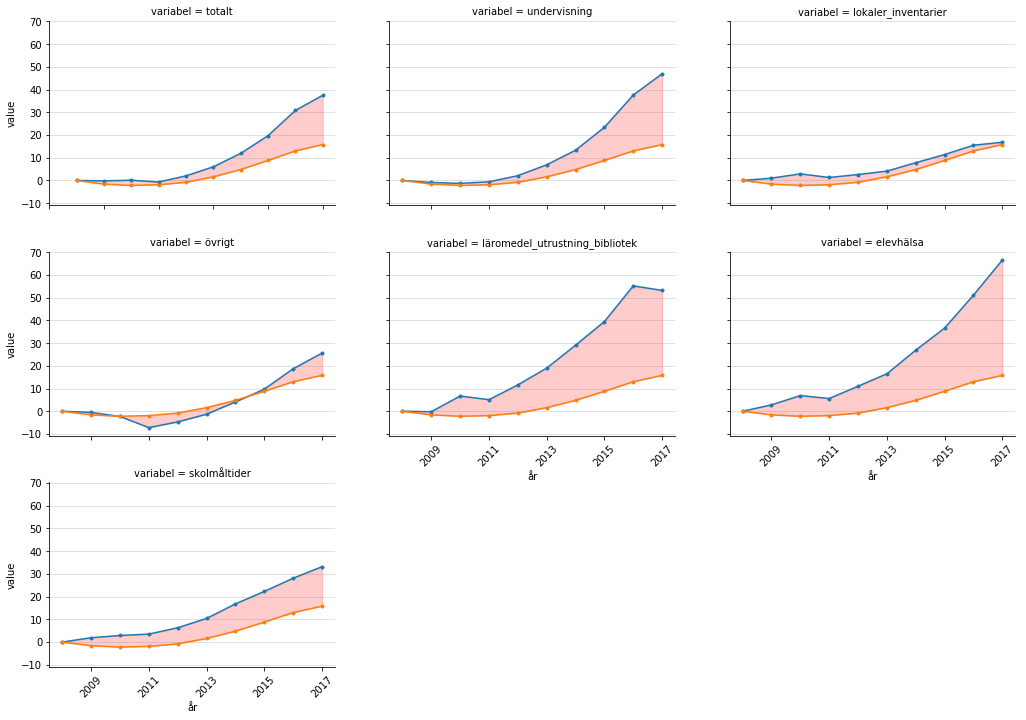

In [49]:
g = sns.FacetGrid(tmp,col='variabel',col_wrap=3,hue='variabler')
g.map(dateplot,'år','value', 'next', 'variabler')

g.set_xticklabels(step=2,rotation=45)
g.fig.set_size_inches(15,10)


for a in g.axes:
    a.grid(True, axis='y', alpha=0.3, color='grey')


In [50]:
df = df.loc[df['variabel']!='elevavgifter']

In [51]:
df.variabel.unique()

array(['totalt', 'undervisning', 'lokaler_inventarier', 'övrigt',
       'läromedel_utrustning_bibliotek', 'elevhälsa', 'skolmåltider'],
      dtype=object)

In [52]:
mapping = dict(zip(['totalt', 'undervisning', 'lokaler_inventarier', 'övrigt',
       'läromedel_utrustning_bibliotek', 'elevhälsa', 'skolmåltider'],
    ['Totalt', 'Undervisning', 'Lokaler och inventarier', 'Övriga kostnader',
     'Läromedel, utrustning och bibliotek', 'Elevhälsa', 'Skolmåltider']))

In [53]:
df.variabel = df.variabel.map(mapping)

In [54]:
os.makedirs('res')

In [55]:
df.sort_values(['variabel','år'])[['år','variabel','andel','förändring_fasta_priser']].to_excel('res/fasta_priser.xlsx',index=False)